# Assignments 3-4

In [1]:
from google.colab import drive

drive.mount("/gdrive", force_remount=True)
!ln -s "/gdrive/My Drive/Statistics/Task 3-4/data" "/content/data"

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import kstest_normal

In [3]:
train_df = pd.read_csv("data/train.csv")
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Problem 5. Linear regression

### 1

In the dataset downloaded from Kaggle, the values in MSSubClass field are actually numbers, but in general they doesn't mean anything as they are just an IDs for values provided in description file. We can consider the values as a categorial variables and decide how to work with them.


---
From the *data_description.txt* file:

        MSSubClass: Identifies the type of dwelling involved in the sale.

            20	1-STORY 1946 & NEWER ALL STYLES
            30	1-STORY 1945 & OLDER
            40	1-STORY W/FINISHED ATTIC ALL AGES
            45	1-1/2 STORY - UNFINISHED ALL AGES
            50	1-1/2 STORY FINISHED ALL AGES
            60	2-STORY 1946 & NEWER
            70	2-STORY 1945 & OLDER
            75	2-1/2 STORY ALL AGES
            80	SPLIT OR MULTI-LEVEL
            85	SPLIT FOYER
            90	DUPLEX - ALL STYLES AND AGES
          120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
          150	1-1/2 STORY PUD - ALL AGES
          160	2-STORY PUD - 1946 & NEWER
          180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
          190	2 FAMILY CONVERSION - ALL STYLES AND AGES

As we consider the variable as a categorial value, we should properly choose the approach to handle it in linear regression task. There were 2 approaches mentioned in the task:
1. **Ordinal encoding.** This type of encoding assigns some ordinal integer number for each distinct category. It is very usefull in case of ordinal data, there variables follow some natural order or ranking.
2. **Dummy variable (One-hot) encoding.** This approach creates $N$ bynary fields, where $N$ is equal to number of distinct categories. Value 1 (or true) means the record corresponds to the category, value 0 (or false) shows that it doesn't. This type of encoding is usefull for nominal data without any order.

As the variable appears to be nominal, **One-hot encoding** approach appears to be more appropriate.



In [ ]:
x = train_df[["MSSubClass"]]
y = train_df["SalePrice"]

lin_reg = LinearRegression()
lin_reg.fit(x, y)

y_pred = lin_reg.predict(x)
r2 = r2_score(y, y_pred)

r2

0.007103815434038263

The LinearRegression cannot work with string values (it raises `ValueError: could not convert string to float`) so it doesn't even make sense to cast it from integer type. The method worked with MSSubClass as with integer values. As we see from $r^2$-score, which is approximatelly equal to $0.007$, the accuracy of the model is really poor.

### 2

In [ ]:
numeric_vars = ["LotFrontage", "LotArea", "YearBuilt", "BsmtFinSF1", "BsmtUnfSF"]

train_df[["Id", *numeric_vars, "SalePrice"]].head(5)

,Id,LotFrontage,LotArea,YearBuilt,BsmtFinSF1,BsmtUnfSF,SalePrice
0,1,65.0,8450,2003,706,150,208500
1,2,80.0,9600,1976,978,284,181500
2,3,68.0,11250,2001,486,434,223500
3,4,60.0,9550,1915,216,540,140000
4,5,84.0,14260,2000,655,490,250000


In [ ]:
train_df[["Id", *numeric_vars, "SalePrice"]].isna().sum()

Id               0
LotFrontage    259
LotArea          0
YearBuilt        0
BsmtFinSF1       0
BsmtUnfSF        0
SalePrice        0
dtype: int64

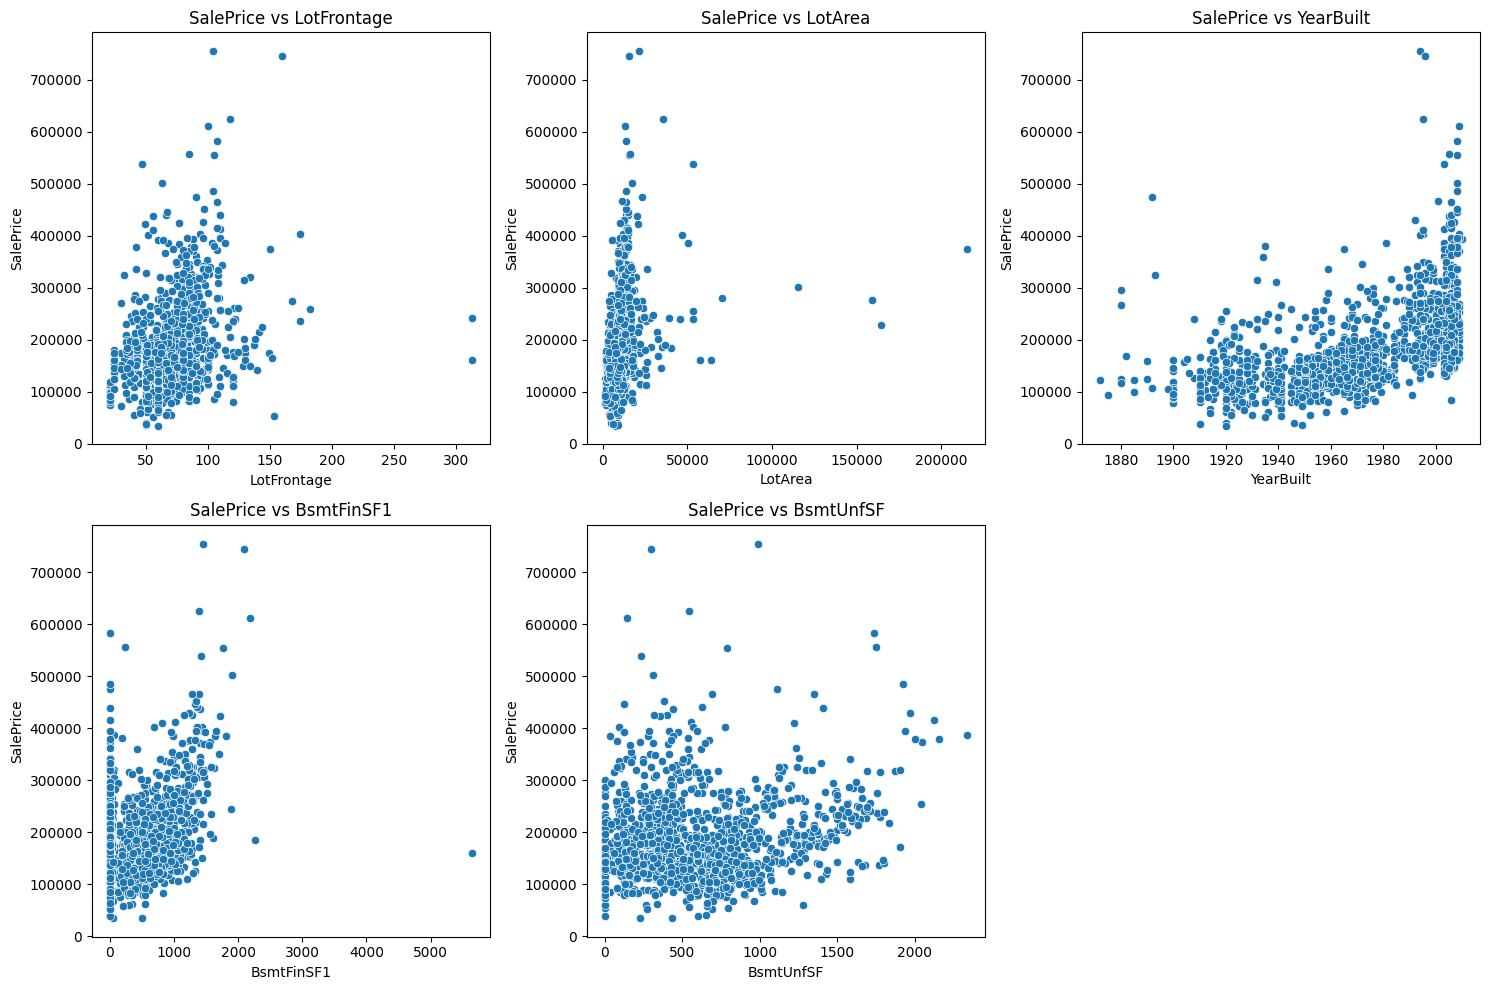

In [ ]:
plt.figure(figsize=(15, 10))

for i, var in enumerate(numeric_vars):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=train_df[var], y=train_df["SalePrice"])
    plt.title(f"SalePrice vs {var}")
    plt.xlabel(var)
    plt.ylabel("SalePrice")

plt.tight_layout()
plt.show()

1. **SalesPrice vs LotFrontage.** Here we see weak positive correlation. There is a problem that LotFrontage column has a lot of missing values and some outliers. To decrease amount of such issues we can fill missing values with some actual value (possibly median value) and apply some transformation such as $log$ to reduce the effect of outliers.
2. **SalesPrice vs LotArea.** There are outliers with big LotArea. $log$ function can stabilize the variance.
3. **SalesPrice vs YearBuilt.** On this plot we see the general trand that indecats that newer houses tend to sell for more, but the relation isn't really linear. Some polynomial function can be used here to capture non-linear dependency better.
4. **SalesPrice vs BsmtFinSF1.** There is a positive correlation but it is weak. On the plot we see some outliers and a lot of records with BsmtFinSF1 equal to 0. Looks like it makes sense to use encoded BsmtFinType1, which can help to identify unfinished properties. The second option is to split the model to with with finished and unfinished properties separatelly.
5. **SalesPrice vs BsmtUnfSF.** It is similar to BsmtFinSF1: outliers and weak positive correlation. Again, here would be better to add some indicator.


### 3

Hypotheses:
*   $H_0$: the slope coefficient ($\beta_1$) of LotArea is equal to 0 (LotArea doesn't have a significant impact on SalesPrices)
*   $H_1$: the slope coefficient is not 0.

The generalized formula of the test statistics is
$$ t_{emp} = \frac{\hat{\beta_j} - \beta_j^*}{\sqrt{\hat{Var(\hat{\beta_j})}}}, $$
where $\hat{\beta_j}$ is a slope coefficient, $\beta_j^*$ is a given value (in our case it is 0) and $\hat{Var(\hat{\beta_j})}$ is the j-th element on the main diagonal of matrix $\hat{\sigma^2}(X'X)^{-1}$.

In our case we can rewrite it as:
$$t_{emp} = \frac{\hat{\beta_1} - 0}{SE(\hat{\beta_1})} = \frac{\hat{\beta_1} - 0}{\sqrt{\frac{\sum_{i=1}^N(y - \hat{y})^2}{(n-2)\sum_{i=1}^N(x - \overline{x})^2}}},$$
where $SE(\hat{\beta_1})$ is the standard error or the coefficient, $\hat{y}$ is the predicted value of SalesPrices and $\overline{x}$ is the mean on LotArea.






  

In [ ]:
x = train_df[["LotArea"]].fillna(0)
y = train_df["SalePrice"]

lin_reg = LinearRegression()
lin_reg.fit(x, y)

y_pred = lin_reg.predict(x)

slope = lin_reg.coef_[0]

df = len(x) - 2  # Degrees of freedom
SE = np.sqrt(np.sum((y - y_pred) ** 2) / (len(x) - 2)) / np.sqrt(
    np.sum((x - np.mean(x)) ** 2)
)

t_statistic = slope / SE

p_value = 2 * stats.t.sf(np.abs(t_statistic), df)

r_squared = lin_reg.score(x, y)
adjusted_r_squared = 1 - (1 - r_squared) * (len(y) - 1) / (len(y) - x.shape[1] - 1)


t_statistic, p_value, r_squared, adjusted_r_squared

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(LotArea    10.444633
 dtype: float64,
 array([1.12313915e-24]),
 0.0696133153821118,
 0.06897519008401998)

The calculated value of the test statistics is equal to 10.4 and p-value is approximatelly 0, leading us to regect the $H_0$ and indicating that there is a statistically significant linear relationship between LotArea and SalePrice.

Goodness-of-fit of the model is denoted by $R^2$ coefficient and is equal to 6.96% in our case. It means that 6.96% of deviation of SalePrice can be explained by change of LotArea. The adjusted $R^2$ is a bit smaller and is equal to 6.89%. It is a statistical measure that indicates how much of the variability in the outcome variable is explained by the independent variables in the model. Unlike regular R-squared, it adjusts for the number of predictors, penalizing for any unnecessary ones. This makes it a more precise indicator of the model's fit, particularly when there are several predictors. The adjusted $R^2$ is very close to $R^2$, indicating that the number of predictors (in this case, just one) is appropriate for the model.









### 4

Hypotheses:
*   $H_0$: all coefficients of MSSubClass dummies is equal to 0 (MSSubClass doesn't have a significant impact on SalesPrices)
*   $H_1$: at least one coefficient of MSSubClass dummies is not equal to 0.

In [ ]:
df_sel = train_df[["MSSubClass", "SalePrice"]]
df_encoded = pd.get_dummies(df_sel, columns=["MSSubClass"])

print(df_encoded.head(5))

ms_sub_class_dummies = df_encoded.columns.str.startswith("MSSubClass_")

model_formula = "SalePrice ~ " + " + ".join(df_encoded.columns[ms_sub_class_dummies])
model = ols(model_formula, data=df_encoded).fit()

num_dummies = len(df_encoded.columns[ms_sub_class_dummies])

R = np.hstack([np.zeros((num_dummies, 1)), np.eye(num_dummies)])
r = np.zeros(num_dummies)

print(f"R = {R},\n\n r = {r}")

test_result = model.f_test((R, r))

test_result.summary()

   SalePrice  MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  \
0     208500              0              0              0              0   
1     181500              1              0              0              0   
2     223500              0              0              0              0   
3     140000              0              0              0              0   
4     250000              0              0              0              0   

   MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  \
0              0              1              0              0              0   
1              0              0              0              0              0   
2              0              1              0              0              0   
3              0              0              1              0              0   
4              0              1              0              0              0   

   MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_16

'<F test: F=694.8564423972986, p=0.0, df_denom=1.44e+03, df_num=15>'

Components of F-test:
*   The matrix $R$ is an identity matrix with dimension equal to the number of dummy variables ($n$) stacked horisontally with all-zero vector on the left side ($n \times 1$). The size of the matrix is $n \times (n + 1)$, in our case it is $15 \times 16$. Each row represents the hypothesis test for the dummy variable being zero.
*   The vector $\mathbf{r}$ is a zero vector of the same length as the number of dummy variables. It represents the $H_0$ that all variables are zero.



As the $p$-value is equal to 0, which is less then the common significance level $\alpha = 0.05$, we can reject the null-hypothesis and conclude that MSSubClass variable has a significant impact on SalePrice.

### 5

Useful links:

1.   Dummy variables in regression model - https://www.linkedin.com/advice/0/how-do-you-use-dummy-variables-regression-models-skills-statistics#:~:text=Dummy%20variables%20can%20be%20used,model%20and%20the%20reference%20category




Economic interpretation of parameters:
1.   **Parameter of LotArea ($\beta_i$):** The parameter represents the change of dependent SalePrice variable when the LotArea changes by 1 unit. If the parameter is equal to 300, it means that each square feet of lot area increases the price by \$300 (if other factors remain constant).
2.   **Parameter of the first dummy of MSSubClass ($\beta_j$):** The first dummy variables is usually ommited from the model to avoid dummy variable trap, meaning that it doesn't have the parameter in the model (link above). If it is included against the standard practice, it would represent the difference in SalePrice between houses in the first MSSubClass category and houses with no category, which is sounds like nonsense as all houses should have a category. \\
  *P.S. If you ommit the first category, the coefficient of any other dummy variable represents the difference in the mean outcome between that category and the reference category.*
3.   **Parameter of BedroomAbvGr ($\beta_k$):** Assuming the factor is significant, its parameter in the regression model represents the change of SalePrice for each additional bedroom above the ground. The same as for LotArea, if the parameter is equal to 300, it means that each square feet of lot area increases the price by \$300 (if other factors remain constant).

---

Economic interpretation of parameters for model with $log$ of SalePrice:

1.   **Parameter of LotArea ($\beta_i$):** Now the parameter represents the percentage change in SalePrice for a one unit increase of LotArea.
2.   **Parameter of the first dummy of MSSubClass ($\beta_j$):** As explained above, the first variable is usually ommited. If included, it would represent the percentage difference in SalePrice related to the reference category.
3.   **Parameter of BedroomAbvGr ($\beta_k$):** Now the parameter represents the percentage change in SalePrice for a one unit increase of BedroomAbvGr.





### 6

In [ ]:
X = train_df[["LotArea"]]
y = train_df["SalePrice"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

alpha = 0.05

confidence_interval = model.conf_int(alpha).loc["LotArea"]

print(f"Confidence interval is in ({confidence_interval[0]}, {confidence_interval[1]})")

t, p = kstest_normal(model.resid)

print(f"Kolmagorov-Smirnov test (test statistics = {t}, p-value = {p})")

Confidence interval is in (1.7055790559836819, 2.494364847431666)
Kolmagorov-Smirnov test (test statistics = 0.11580791274724667, p-value = 0.0009999999999998899)


The 95% confidence interval for LotArea $\in (1.7, 2.49)$. It means that with 95% of confidence we can say that the parameter lies in the range. It also means that with every one unit increase of LotArea, the SalePrice will increase by number from (approximatelly) 1.7 to 2.49.

If the range doesn't contain 0, we can say that the variable is statistically significant with our confidence interval. As it doesn't for $\alpha = 0$, we assume that LotArea is a significant predictor of SalePrice.

---

Hypotheses:
*   $H_0$: the sample follows normal distribution
*   $H_1$: the sample doesn't follow normal distribution.

The check if the sample follows normal distribution we can use Kolmagorov-Smirnov test. As the $p-$value of the goodness-of-fit test is lower than the common significance level $\alpha = 0.05$, we can reject the $H_0$ and conclude that the sample doesn't follow normal distribution.



### 7

There are several model selection methods that can be used to choose the best model: forward selection, backward selection and stepwise selection.

*   **Forward selection**: start with no predictors, sequentally add one more predictor with highest contribution to the model fit, stop the process when non of the remaining variables contributes significantly to the goodness of the model.
*   **Backward selection**: start with all variables, sequentally remove one predictor with lowest contribution to the model fit, stop the process when all remaining variables have significant contribution.
*   **Stepwise selection**: this method involved both forward and backward selection. It starts with forward selection, adding one variables with higher contribution to the model. After adding each new variable, it checks if any of the variables already in the model have become insignificant and can be removed. The process can be stopped when no variables can be added or removed.




In [ ]:
include_categorial_variables = False

if include_categorial_variables:
    df_to_process = pd.get_dummies(train_df, drop_first=True)
    df_to_process = df_to_process.select_dtypes(include=["float64", "int64", "uint8"])
    df_to_process = df_to_process.fillna(df_to_process.mean())
else:
    df_to_process = train_df.select_dtypes(include=["float64", "int64"])
    df_to_process = df_to_process.fillna(df_to_process.mean())

In [ ]:
# Stepwise Model Selection
def stepwise_selection(df, target, alpha=0.05):
    predictors = [col for col in df.columns if col != target]

    selected_predictors = []
    best_aic = float("inf")
    while True:
        changed = False
        # forward step
        excluded = list(set(predictors) - set(selected_predictors))
        new_aic = best_aic
        best_feature = None
        for new_column in excluded:
            model = sm.OLS(
                df[target], sm.add_constant(df[selected_predictors + [new_column]])
            ).fit()
            if model.aic < new_aic:
                new_aic = model.aic
                best_feature = new_column
        if best_feature is not None:
            selected_predictors.append(best_feature)
            changed = True
            best_aic = new_aic

        # backward step
        model = sm.OLS(df[target], sm.add_constant(df[selected_predictors])).fit()
        pvalues = model.pvalues.iloc[1:]  # use all coefs except intercept
        worst_pval = pvalues.max()
        if worst_pval > alpha:
            changed = True
            worst_feature = pvalues.idxmax()
            selected_predictors.remove(worst_feature)
            best_aic = model.aic

        if not changed:  # no more steps improve the accuracy
            break

    return selected_predictors


selected_predictors = stepwise_selection(df_to_process, "SalePrice")

df = df_to_process[selected_predictors + ["SalePrice"]]

# Fit the final model
final_model = sm.OLS(
    df_to_process["SalePrice"], sm.add_constant(df_to_process[selected_predictors])
).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     326.9
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:43:51   Log-Likelihood:                -17325.
No. Observations:                1460   AIC:                         3.469e+04
Df Residuals:                    1440   BIC:                         3.480e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.824e+05   1.24e+05     -7.937      0.000   -1.23e+06    -7.4e+05
OverallQual   1.749e+04   1166.621     14.991      0.000    1.52e+04    1.98e+04
GrLivArea       45.3815      4.091     11.094      0.000      37.357      53.406
BsmtFinSF1       9.7838      3.044      3.214      0.001       3.812      15.756
GarageCars     1.07e+04   1684.098      6.355      0.000    7398.215     1.4e+04
MSSubClass    -170.6205     24.985     -6.829      0.000    -219.632    -121.609
YearBuilt      296.8654     53.685      5.530      0.000     191.555     402.176
BedroomAbvGr -1.035e+04   1658.105     -6.243      0.000   -1.36e+04   -7099.152
OverallCond   4370.5458   1001.875      4.362      0.000    2405.256    6335.836
LotArea          0.4058      0.100      4.065      0.000       0.210       0.602
MasVnrArea      32.2189      5.874      5.485      0.000      20.695      43.742
BsmtFullBath  8908.7481   2390.333      3.727      0.000    4219.840    1.36e+04
TotRmsAbvGrd  5145.4541   1222.856      4.208      0.000    2746.683    7544.225
WoodDeckSF      24.8062      7.855      3.158      0.002       9.397      40.215
ScreenPorch     51.4548     16.852      3.053      0.002      18.398      84.511
TotalBsmtSF      9.6730      3.131      3.089      0.002       3.531      15.815
YearRemodAdd   170.8079     65.257      2.617      0.009      42.800     298.816
KitchenAbvGr -1.252e+04   4985.818     -2.510      0.012   -2.23e+04   -2735.757
Fireplaces    3682.9116   1719.936      2.141      0.032     309.063    7056.760
FullBath      5072.2664   2581.211      1.965      0.050       8.931    1.01e+04
==============================================================================
Omnibus:                      654.981   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115171.443
Skew:                          -0.970   Prob(JB):                         0.00
Kurtosis:                      46.468   Cond. No.                     2.01e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Lets take a deeper look into how the **stepwise selection method** works. The steps are described below:
1.   **Initialization:** the model starts with NO selected predictors and best error equal to infinity.
2.   **Forward selection:** add new predictor
    1. Iterate through all predictors that are not yet selected;
    2. Compute the error of the model with current predictor added;
    3. Add predictor with the lowest error to the general model.
3. **Backward selection:** remove some predictor
    1. Fit the model with currently selected predictors;
    2. Find the predictor with highest p-value;
    3. Remove the predictor from the model if the p-value is higher than some choosed significance level;
4. **Loop:** repeat steps 2-3 until no other addition and removing are done (no more actions that can increase the accuracy) on each increment.



### 8

TODO: discuss the plots and record with highest leverage

In [ ]:
X = df[selected_predictors]
y = df["SalePrice"]

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Calculate residuals, Cook's distance, and leverage
influence = model.get_influence()
summary_frame = influence.summary_frame()

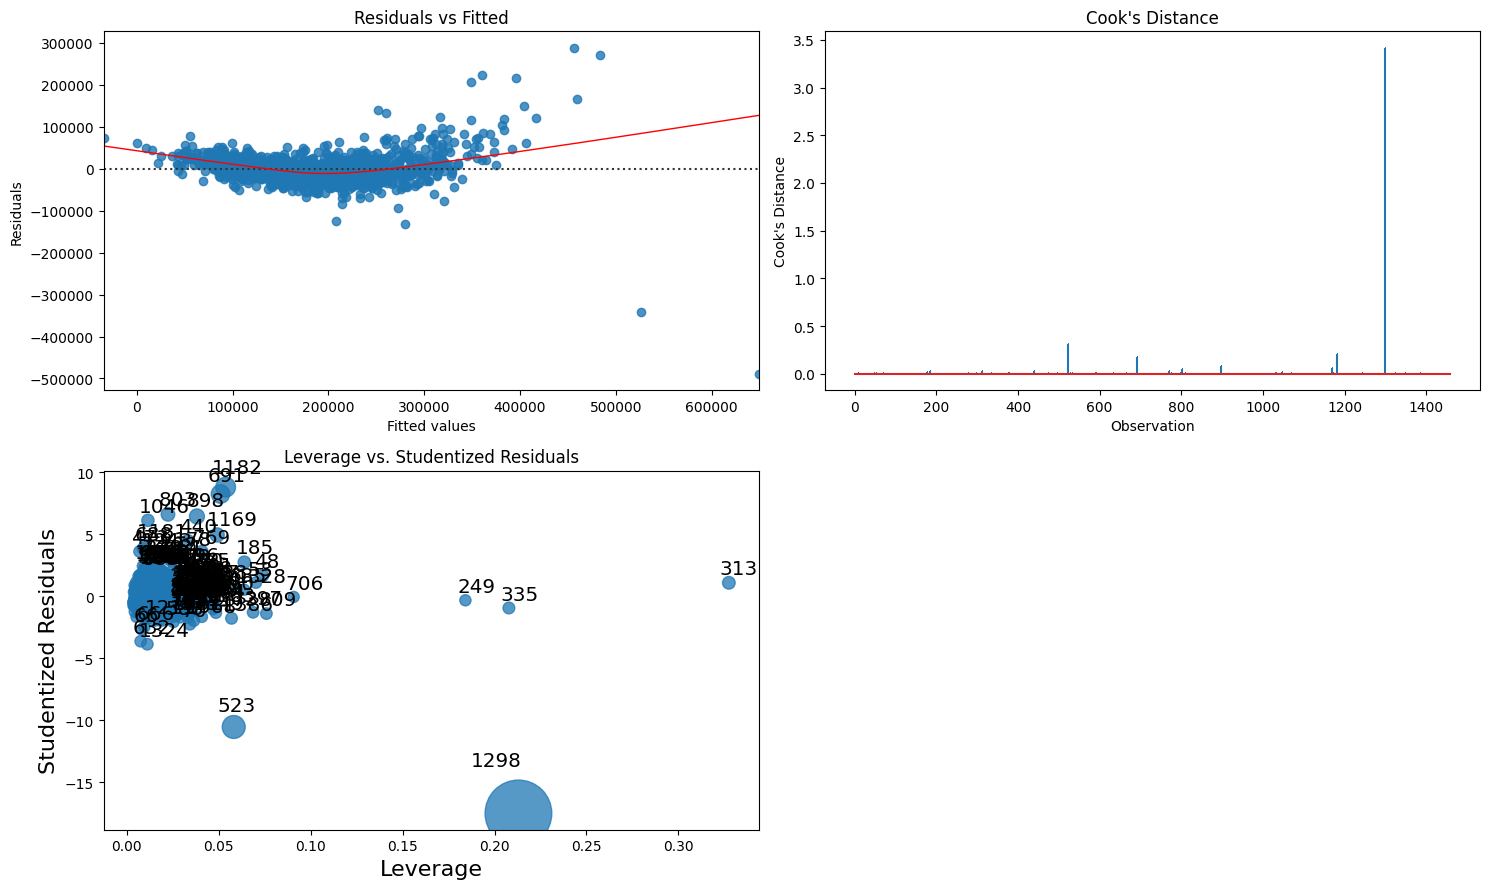

(313,
 dfb_const           0.011742
 dfb_OverallQual     0.072068
 dfb_GrLivArea      -0.086654
 dfb_BsmtFinSF1     -0.056080
 dfb_GarageCars     -0.048228
 dfb_MSSubClass      0.066241
 dfb_YearBuilt       0.018944
 dfb_BedroomAbvGr   -0.029063
 dfb_OverallCond    -0.003674
 dfb_LotArea         0.730583
 dfb_MasVnrArea     -0.029281
 dfb_BsmtFullBath    0.050130
 dfb_TotRmsAbvGrd    0.044298
 dfb_WoodDeckSF     -0.115459
 dfb_ScreenPorch    -0.021626
 dfb_TotalBsmtSF    -0.001550
 dfb_YearRemodAdd   -0.031754
 dfb_KitchenAbvGr   -0.018100
 dfb_Fireplaces     -0.050881
 dfb_FullBath        0.021100
 cooks_d             0.028350
 standard_resid      1.079151
 hat_diag            0.327449
 dffits_internal     0.752994
 student_resid       1.079213
 dffits              0.753037
 Name: 313, dtype: float64)

In [ ]:
# Plots
fig, ax = plt.subplots(2, 2, figsize=(15, 9))

# 1. Residuals plot
sns.residplot(
    x=model.predict(X),
    y=model.resid,
    lowess=True,
    ax=ax[0, 0],
    line_kws={"color": "red", "lw": 1},
)
ax[0, 0].set_title("Residuals vs Fitted")
ax[0, 0].set_xlabel("Fitted values")
ax[0, 0].set_ylabel("Residuals")

# 2. Cook's distance
ax[0, 1].stem(summary_frame.index, summary_frame["cooks_d"], markerfmt=",")
ax[0, 1].set_title("Cook's Distance")
ax[0, 1].set_xlabel("Observation")
ax[0, 1].set_ylabel("Cook's Distance")

# 3. Leverage plot
sm.graphics.influence_plot(model, ax=ax[1, 0], criterion="cooks")
ax[1, 0].set_title("Leverage vs. Studentized Residuals")

ax[1, 1].remove()

plt.tight_layout()
plt.show()

# Identify the observation with the highest leverage
highest_leverage = summary_frame["hat_diag"].idxmax()
highest_leverage, summary_frame.loc[highest_leverage]

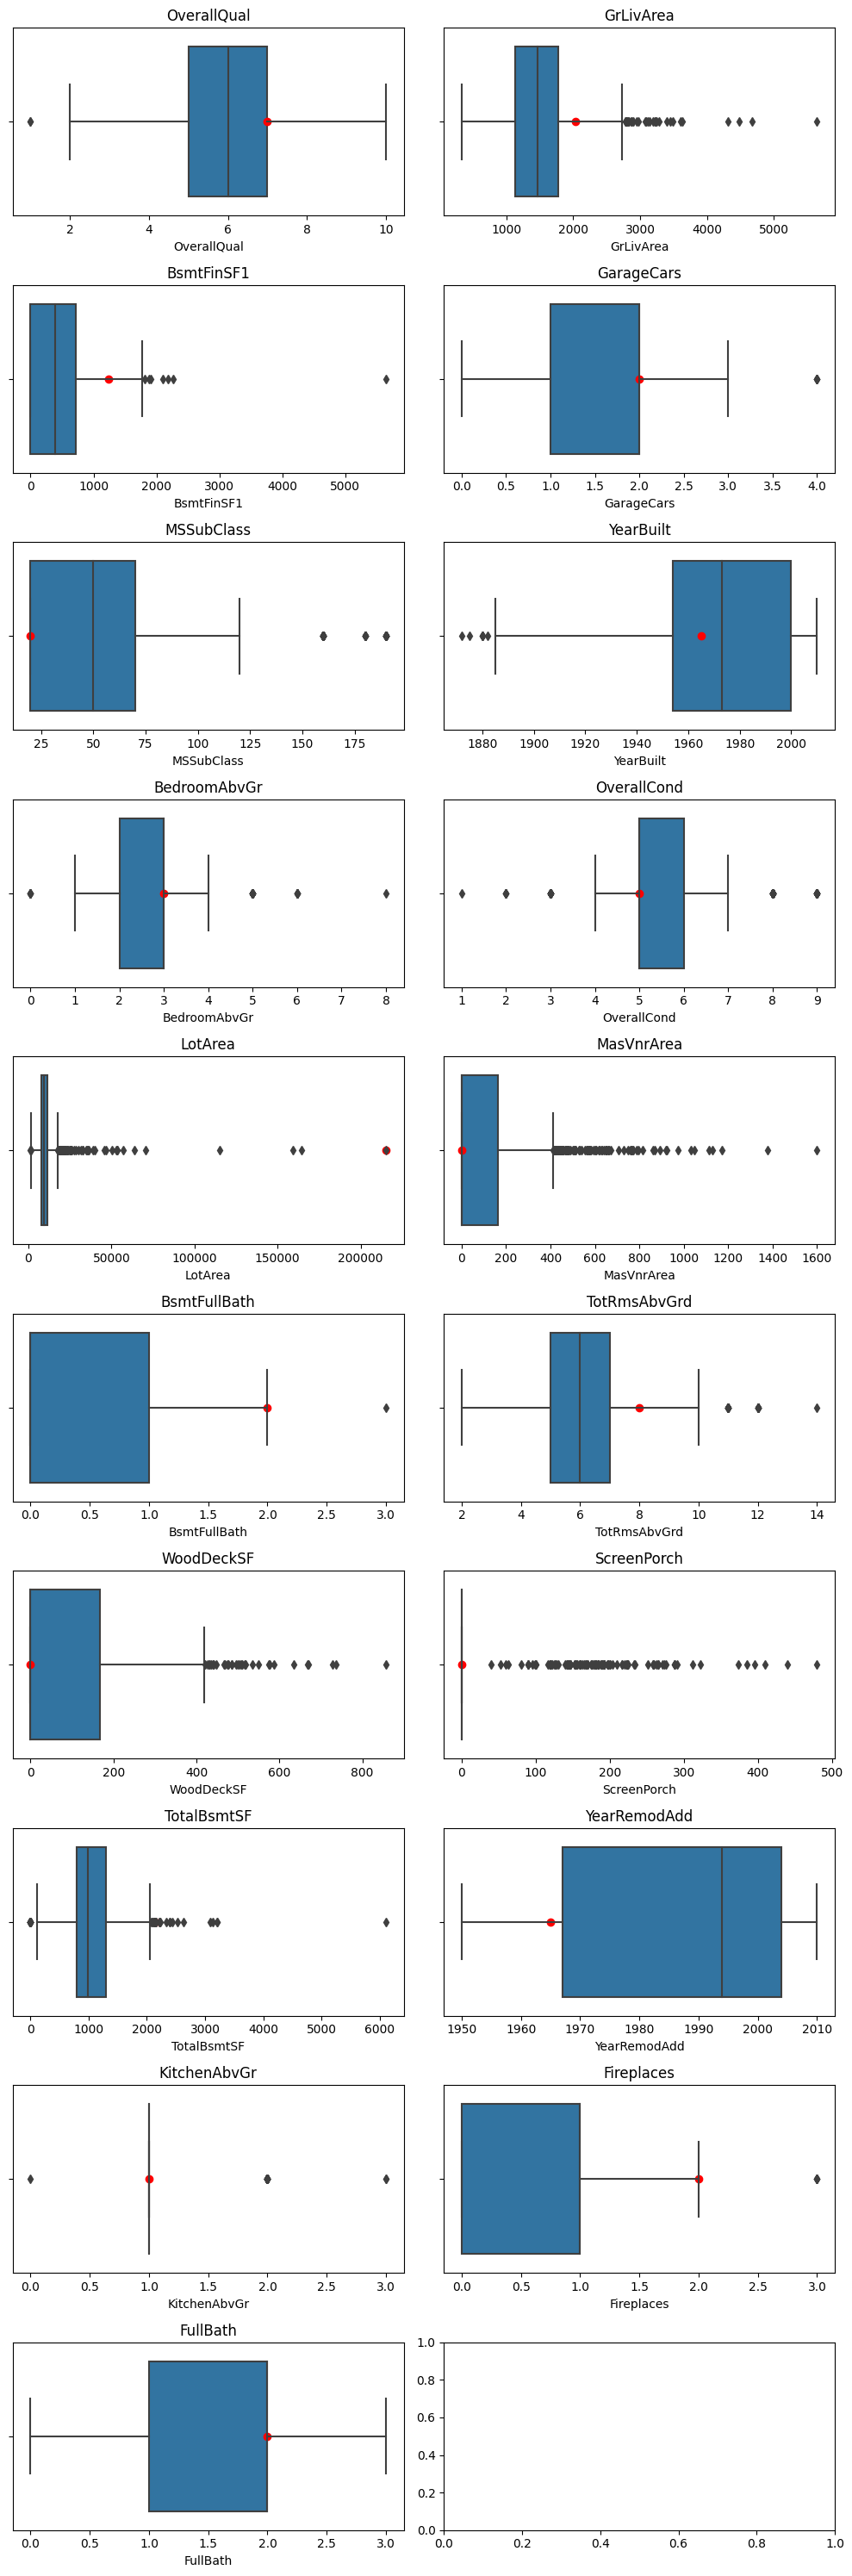

In [ ]:
highest_leverage_obs = df.loc[highest_leverage, selected_predictors]

# 1. Box-plots for Interval Scaled Variables
fig, axes = plt.subplots((len(selected_predictors) + 1) // 2, 2, figsize=(10, 30))
for i, col in enumerate(selected_predictors):
    sns.boxplot(x=df[col], ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].scatter(highest_leverage_obs[col], 0, color="red")
    axes[i // 2, i % 2].set_title(col)

plt.tight_layout()
plt.show()

### 9

There are a lot of different method on how to deal with missing values. Lets discuss and implement 2 of them: mean/median replacement and KNN replacement.



1.   **Mean/median replacement:**
    1. Model: Replace the missing value with a mean/median value of the column;
    2. Motivation: This approach is simple and effective and works well when the amount of missing data is small.
    3. Implementation: `fillna()` function in Pandas with appropriate parameter.

2.   **K-Neairest Neighbors replacement:**
    1. Model: Replace the missing value with a mean value of its nearest neighbors.
    2. Motivation: The approach is a bit more complicated but it makes into account the similarity between features, which means that if fills with more realistic value.
    3. Implementation: `KNNImputer` from Scikit-Learn.



In [ ]:
np.random.seed(5)
random_indices = np.random.choice(train_df.index, size=5, replace=False)
df_with_missing_records = train_df.copy()
df_with_missing_records.loc[random_indices, "LotArea"] = np.nan

df_with_missing_records.loc[random_indices]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
756,757,60,RL,68.0,NaN,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,212000
923,924,120,RL,50.0,NaN,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,193000
1423,1424,80,RL,NaN,NaN,Pave,NaN,IR1,Lvl,AllPub,...,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970
217,218,70,RM,57.0,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Family,107000
653,654,50,RM,60.0,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,135000


In [ ]:
lotarea_mean = train_df["LotArea"].mean()
lotarea_median = train_df["LotArea"].median()
data_mean_imputed = df_with_missing_records.copy()
data_mean_imputed["LotArea"] = data_mean_imputed["LotArea"].fillna(lotarea_mean)
data_median_imputed = df_with_missing_records.copy()
data_median_imputed["LotArea"] = data_median_imputed["LotArea"].fillna(lotarea_median)

# 2. KNN Imputation
# We'll use KNNImputer from Scikit-learn
knn_imputer = KNNImputer(n_neighbors=5)  # default value of k is 5
data_knn_imputed = df_with_missing_records.copy()
data_knn_imputed = pd.get_dummies(data_knn_imputed, drop_first=True)
data_knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(data_knn_imputed), columns=data_knn_imputed.columns
)

# Outputting the original and imputed values for comparison
original_values = train_df.loc[random_indices, "LotArea"]
mean_imputed_values = data_mean_imputed.loc[random_indices, "LotArea"]
median_imputed_values = data_median_imputed.loc[random_indices, "LotArea"]
knn_imputed_values = data_knn_imputed.loc[random_indices, "LotArea"]

comparison_df = pd.concat(
    [
        original_values.rename("original"),
        mean_imputed_values.rename("mean"),
        median_imputed_values.rename("median"),
        knn_imputed_values.rename("knn"),
    ],
    axis=1,
)

comparison_df

,original,mean,median,knn
756,10769,10516.828082,9478.5,9757.8
923,8012,10516.828082,9478.5,8326.4
1423,19690,10516.828082,9478.5,13791.0
217,9906,10516.828082,9478.5,6665.4
653,10320,10516.828082,9478.5,10809.2


In [ ]:
comparison_df["abs_diff_mean"] = (
    comparison_df["original"] - comparison_df["mean"]
).abs()
comparison_df["abs_diff_median"] = (
    comparison_df["original"] - comparison_df["median"]
).abs()
comparison_df["abs_diff_knn"] = (comparison_df["original"] - comparison_df["knn"]).abs()

sum_abs_diff_mean = comparison_df["abs_diff_mean"].sum()
sum_abs_diff_median = comparison_df["abs_diff_median"].sum()
sum_abs_diff_knn = comparison_df["abs_diff_knn"].sum()

sum_abs_diff_mean, sum_abs_diff_median, sum_abs_diff_knn

(12737.828082191782, 14237.5, 10954.400000000001)

On the results above we see that mean/median approach replaces all the missing values with the same value, which can be useful because of its simplisity. The KNN approach does a better job: it fills the missing value with more realistic value, looking at the "neighbors" of the record.

Based on these 5 records we see, that sum of the differences is more or less similar for all approaches but best result is from KNN approach. To choose which one to use in the real tasks, we need to understand the nature of the data.

### 10

In [ ]:
predictors = selected_predictors

linear_model = sm.OLS(df["SalePrice"], sm.add_constant(df[predictors])).fit()
linear_predictions = linear_model.predict(sm.add_constant(df[predictors]))

log_linear_model = sm.OLS(
    np.log(df["SalePrice"]), sm.add_constant(df[predictors])
).fit()
log_linear_predictions = log_linear_model.predict(sm.add_constant(df[predictors]))
log_linear_predictions_transformed = np.exp(log_linear_predictions)

df["augmented_linear"] = log_linear_predictions - np.mean(log_linear_predictions)
augmented_linear_model = sm.OLS(
    df["SalePrice"], sm.add_constant(df[predictors + ["augmented_linear"]])
).fit()

df["augmented_log_linear"] = linear_predictions - np.exp(
    np.mean(log_linear_predictions)
)
augmented_log_linear_model = sm.OLS(
    np.log(df["SalePrice"]), sm.add_constant(df[predictors + ["augmented_log_linear"]])
).fit()

linear_vs_log = augmented_linear_model.t_test("augmented_linear = 0")
log_vs_linear = augmented_log_linear_model.t_test("augmented_log_linear = 0")

print(linear_vs_log.summary())
print(log_vs_linear.summary())

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          1.058e+05   1.33e+04      7.942      0.000    7.96e+04    1.32e+05
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          -2.47e-06   4.58e-07     -5.390      0.000   -3.37e-06   -1.57e-06


<ipython-input-42-a55386132f8b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['augmented_linear'] = log_linear_predictions - np.mean(log_linear_predictions)
<ipython-input-42-a55386132f8b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['augmented_log_linear'] = linear_predictions - np.exp(np.mean(log_linear_predictions))


### 11

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_score

target = "SalePrice"

data = train_df.fillna(train_df.median())

X_full = data.drop([target, "Id"], axis=1)
X_selected = data[selected_predictors]
y = data[target]

X_full = pd.get_dummies(X_full, drop_first=True)

model = LinearRegression()

# Perform Leave-One-Out Cross-Validation for both models
loo = LeaveOneOut()
scores_loo_full = cross_val_score(
    model, X_full, y, cv=loo, scoring="neg_mean_squared_error"
)
scores_loo_selected = cross_val_score(
    model, X_selected, y, cv=loo, scoring="neg_mean_squared_error"
)

# Perform 5-Fold Cross-Validation for both models
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kfold_full = cross_val_score(
    model, X_full, y, cv=kf, scoring="neg_mean_squared_error"
)
scores_kfold_selected = cross_val_score(
    model, X_selected, y, cv=kf, scoring="neg_mean_squared_error"
)

results = {
    "MSE of full model with LeaveOneOut method": -np.mean(scores_loo_full),
    "MSE of selected model with LeaveOneOut method": -np.mean(scores_loo_selected),
    "MSE of full model with 5-Fold method": -np.mean(scores_kfold_full),
    "MSE of selected model with 5-Fold method": -np.mean(scores_kfold_selected),
}

for name, value in results.items():
    print(f"{name}: {value:,}")

<ipython-input-44-e44eea193854>:7: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = train_df.fillna(train_df.median())


MSE of full model with LeaveOneOut method: 587,882,684,108.9537
MSE of selected model with LeaveOneOut method: 1,342,926,752.9089708
MSE of full model with 5-Fold method: 1,863,643,275.8652108
MSE of selected model with 5-Fold method: 1,443,721,755.55611


## Problem 6. Regression techniques

### 1

#### (a)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


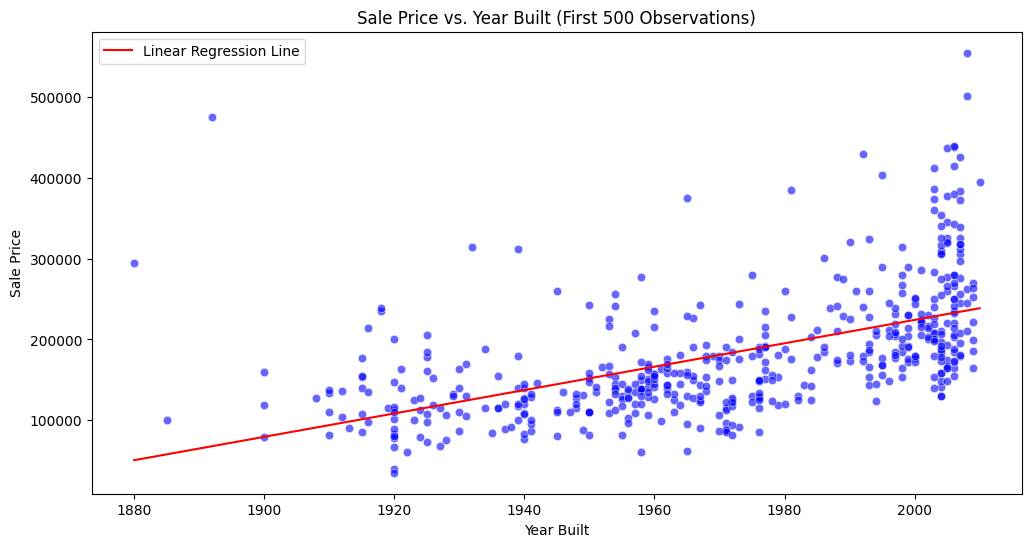

In [ ]:
data_subset = data.iloc[:500]

X = data_subset[["YearBuilt"]]
y = data_subset["SalePrice"]

linear_model = LinearRegression()
linear_model.fit(X, y)

x_range = np.linspace(X.min(), X.max(), 100)
y_pred = linear_model.predict(x_range)

plt.figure(figsize=(12, 6))
sns.scatterplot(x="YearBuilt", y="SalePrice", data=data_subset, color="blue", alpha=0.6)
plt.plot(x_range, y_pred, color="red", label="Linear Regression Line")
plt.title("Sale Price vs. Year Built (First 500 Observations)")
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.legend()
plt.show()

#### (b)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


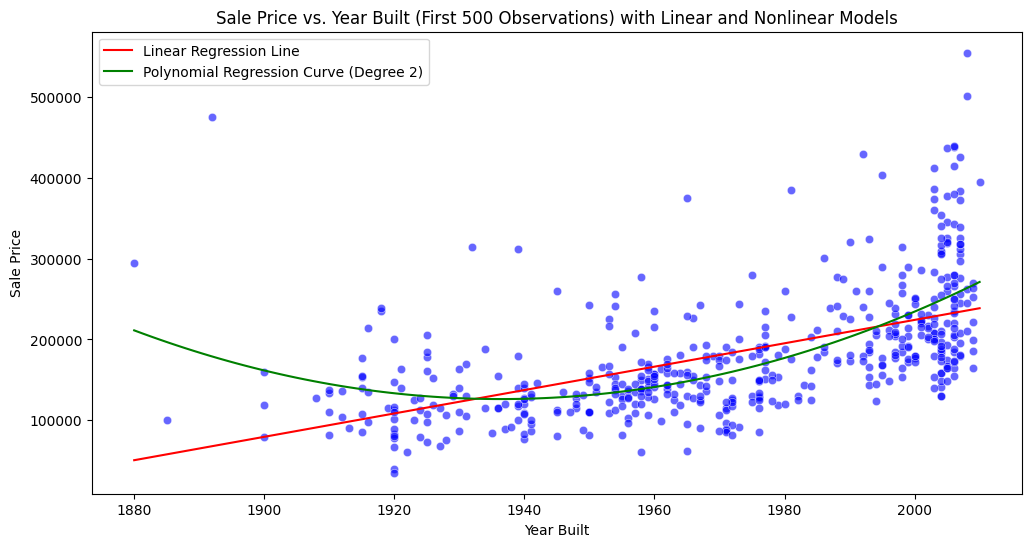

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

degree = 2
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

nonlinear_model = LinearRegression()
nonlinear_model.fit(X_poly, y)

x_poly_range = poly_features.transform(x_range)
y_poly_range = nonlinear_model.predict(x_poly_range)

plt.figure(figsize=(12, 6))
sns.scatterplot(x="YearBuilt", y="SalePrice", data=data_subset, color="blue", alpha=0.6)
plt.plot(x_range, y_pred, color="red", label="Linear Regression Line")
plt.plot(
    x_range, y_poly_range, color="green", label="Polynomial Regression Curve (Degree 2)"
)
plt.title(
    "Sale Price vs. Year Built (First 500 Observations) with Linear and Nonlinear Models"
)
plt.xlabel("Year Built")
plt.ylabel("Sale Price")
plt.legend()
plt.show()

In [ ]:
results = {
    "MSE of linear model": mean_squared_error(y, linear_model.predict(X)),
    "MSE of nonlinear model": mean_squared_error(y, nonlinear_model.predict(X_poly)),
}

for name, value in results.items():
    print(f"{name}: {value:,}")

MSE of linear model: 4,297,426,767.369774
MSE of nonlinear model: 3,712,908,640.5049834


The non-linear (quadratic) model with a lower MSE, fits the data better than the linear model. It means that the relationship between YearBuilt and SalePrice can be captured more accurately by a non-linear model, at least for the first 500 observations.

#### (c)

The classical tests and inferences, such as t-test and F-test are not directly applicable to the NSL (Nonlinear Least Squares) estimators due to several reasons. First of all, NLS estimation can result in multiple local minima, leading to estimator variability that classical tests don't capture well. Also, nonlinear regression doesn't always follow normal distribution, assumed in linear regression, making classical test less reliable.



#### (d)

Among the biggest problems that might arise when we decide to fit non-linear regression using all explanatory variables are **overfitting** and **multicollinearity**.


*   Overfitting occurs when the model becomes **too complex** and it starts capture the "noise" of the data rather than relationship that are under-the-hood.
*   Multicollinearity occurs when the explanatory **variables are highly correlated** with each other. It can "hide" the true relation leading to unreliable model results.

Also, there can be some other issues such as sparsity (many features have small impact on target), interpretation issues, model complexity and even model selection.



### 2

#### (a)

In lasso regression, the word LASSO stands for least absolute shrinkage and selection operator. It is a regularization technique that can help get more accurate prediction. In simple words, the idea behind this is not only minimize  the sum of squared residuals, but also apply some penalty on the size of coefficients (coefficient multiplied by some predefined lambda).

In general, when we use this technique, under-the-hood 2 additional steps are done: coefficient shrinkage (to reduce complexity and overfitting) and feature selection (reduct coefficient of some variables to zero).

This technique can be useful in cases, when we have a large number of predictors and some of them can be irrelevant for the dependent variable. Simple linear regression can cause overfitting, while lasso regression will shrink some predictors to zero, decreasing the complexity, simultaneously increasing generalizability.

To understand why we should maximize the objective function numerically in contrary to ridge regression technique, let's look into the function for both of them:

$$ \text{Ridge regression:} \qquad  \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{k} \beta_j^2 \rightarrow \min,
$$

$$ \text{Lasso regression:} \qquad  \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{k} |\beta_j| \rightarrow \min,
$$

As we can see, in the ridge regression the penalty term is quadratic (and thus deferentiable), unlike in lasso regression, where it takes an absolute value and thus is non-deferentiable in zero. This non-deferentiability introduces needs in ONLY numerical omptimizations.

#### (b)

The scaling is crucial in the case of lasso regression due to several factors:


*   Penalty: As the penalty in this type of regression is an absolute value, when the variables are not scaled, it is not applied uniformelly. In means that values with bigger units of measure will have smaller coefficient. The standartization ensures that the penalty can be applied uniformelly to all variables.
*   Interpretability: When all variables have the same scale it gets easier to compare impact of coefficients of variables in relation to each other.



In [46]:
from sklearn.preprocessing import StandardScaler

train_df = train_df.drop("Id", axis=1)

continuous_vars = train_df.select_dtypes(include=["float64", "int64"]).columns
categorical_vars = train_df.select_dtypes(include=["object"]).columns

scaler = StandardScaler()
data_scaled = train_df.copy()
data_scaled[continuous_vars] = scaler.fit_transform(data_scaled[continuous_vars])

data_scaled[continuous_vars].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.288653,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273
1,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,-0.288653,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288
2,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.288653,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154
3,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.288653,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281
4,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,-0.288653,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843


Categorial variables are usually encoded as a dummy variables before being used in the regression model. It creates from one factor variables several binary variables.

Of cource the scaling can be applied to the binary variables, but they are already bounded with values 0 and 1. However, applying the scaling uniformelly to all the variables, including binary, we ensures consistency.

#### (c)

<ipython-input-63-77b0d48708ce>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_scaled = data_scaled.fillna(data_scaled.mean())


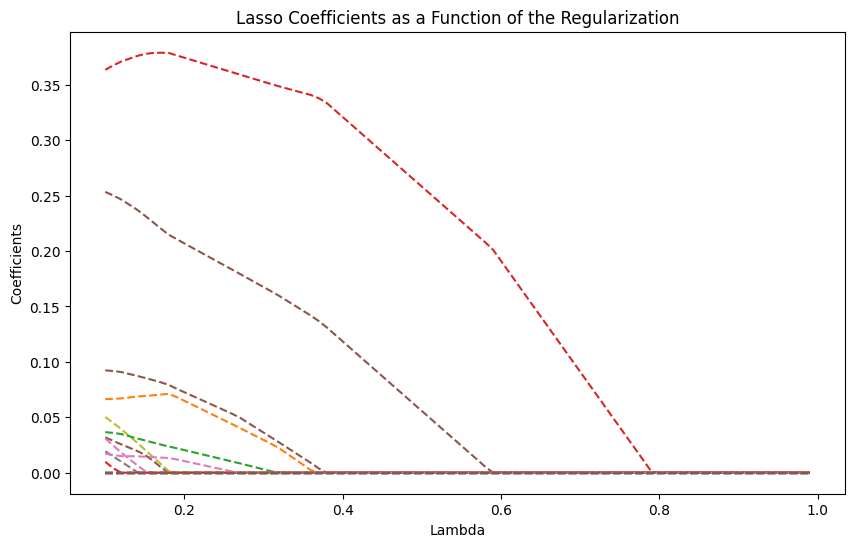

0.008481436435192757

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, LassoCV

data_scaled = data_scaled.fillna(data_scaled.mean())
X = data_scaled[continuous_vars].drop("SalePrice", axis=1)
y = data_scaled["SalePrice"]

alphas = np.arange(0.1, 1, 0.01)

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)


plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefs, linestyle="--")
plt.xlabel("Lambda")
plt.ylabel("Coefficients")
plt.title("Lasso Coefficients as a Function of the Regularization")
plt.axis("tight")
plt.show()

lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X, y)
optimal_alpha = lasso_cv.alpha_
optimal_alpha

On the plot above we see that increasing lambda leads to more coefficients being shrinking to zero. It demonstrates "regularization", which applies penalties for large coefficients $\beta$.

From the cross-validation we found that the optimal $\lambda$ is approximatelly equal to 0.0084. This lambda balances model complexity and fitting accuracy.

#### (d)

From the comparison on ridge regression and multiple linear regression we can expect following:


*   Coefficient size: the estimated paratemers of ridge regression will be smaller in magnitude due to regularization.
*   Variance: the variance of the ridge regression estimated will be typically lower compared MLR. This is also because of stabilization of the estimates by penalties.
*   Bias: reducing the variance, ridge regression introduces bias, leading to better out-of-sample prediction error.



In [69]:
from sklearn.linear_model import Ridge, RidgeCV

ridge_cv = RidgeCV(cv=20)
ridge_cv.fit(X, y)
optimal_alpha = ridge_cv.alpha_
optimal_alpha

ridge = Ridge(alpha=optimal_alpha)
ridge.fit(X, y)

linear_regression = LinearRegression()
linear_regression.fit(X, y)

print(ridge.coef_)
print(linear_regression.coef_)

[-0.09461529 -0.01608196  0.05353671  0.29799106  0.06421841  0.10049127
  0.03745228  0.07195344  0.05522649 -0.00268328 -0.00151886  0.05489949
  0.1053262   0.11831319 -0.00092051  0.17568711  0.06049664  0.0058314
  0.02636502 -0.0098544  -0.10130401 -0.0347264   0.10329477  0.03362332
  0.03760694  0.10264256 -0.00678403  0.03810347 -0.00202995  0.00889632
  0.00756828  0.03902249 -0.01451699 -0.00449238 -0.00146112 -0.01295101]
[-9.65604760e-02 -1.71746507e-02  5.38361227e-02  3.01678036e-01
  6.54637638e-02  1.03364526e-01  3.53724179e-02  7.15708456e-02
 -4.35877761e+10 -1.54167458e+10 -4.22277539e+10  4.19256073e+10
  2.40981038e+11  2.72111775e+11  3.03093954e+10 -3.27560333e+11
  6.11056870e-02  5.99284321e-03  2.37596629e-02 -1.21108821e-02
 -1.03665993e-01 -3.38989859e-02  1.03690754e-01  3.22604592e-02
  3.76393754e-02  1.05649109e-01 -1.13173232e-02  3.78218601e-02
 -2.40368522e-03  9.09982928e-03  7.47229910e-03  3.92327782e-02
 -1.46585084e-02 -4.52686010e-03 -1.687964